In [75]:
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt
import time
from scipy.stats import laplace, norm
from scipy.optimize import curve_fit
#from scipy.stats import norm
from scipy.stats import anderson_ksamp, ks_2samp

%matplotlib inline

In [2]:
random_test_systems = pd.read_csv("../csvs/random/deltatimes.csv", index_col =0)
random_test_systems.head(2)

,runstring,t,t_shadow
0,0000000.bin,1.235644e+07,8.315081e+07
1,0000001.bin,1.348749e+05,2.133072e+05


In [14]:
#pull up gaussian fits, and the P value significance, to take all systems with above 1-e6.
#this is a reasonable threshold because higher than that removes many systems, and lower than that includes many odd systems

random_frame = pd.read_csv("../csvs/random/Gaussian_Fits_266.csv")
random_significances = pd.read_csv("../csvs/random/signficance_scores_new_scipy.csv")

good_fits = random_significances[random_significances["KS_P"]>6.2e-18]
random_valid_gaus_params = random_frame[ random_frame["ID"].isin(good_fits["ID"]) ]
print(random_valid_gaus_params.shape)


random_trimmed = random_test_systems[(random_test_systems["t"]<1e7) & (random_test_systems["t"]>1e4)
                    & (random_test_systems["t_shadow"]<1e7)& (random_test_systems["t_shadow"]>1e4)]
print(random_trimmed.shape)

random_trimmed_ids = random_valid_gaus_params["ID"].values
random_trimmed_info = random_frame.loc[ random_frame["ID"].isin(random_trimmed_ids) ]
print (random_trimmed_info.shape)

(230, 8)
(4825, 3)
(230, 8)


In [29]:
res_test_systems = pd.read_csv("../csvs/resonant/deltatimes.csv")
res_test_systems.head()

,ID,t,t_shadow
0,0.0,5.330628e+03,9.377841e+03
1,1.0,9.999999e+07,9.999999e+07
2,2.0,9.999999e+07,9.999999e+07
3,3.0,5.946887e+06,3.941298e+06
4,4.0,3.711381e+05,6.345772e+05


In [30]:
res_frame = pd.read_csv("../csvs/resonant/Gaussian_Fits_317.csv")
res_significances = pd.read_csv("../csvs/resonant/res_signficance_scores_new_scipy.csv")

good_fits = res_significances[res_significances["KS_P"]>1.24e-5]
res_valid_gaus_params = res_frame[ res_frame["ID"].isin(good_fits["ID"]) ]
print(res_valid_gaus_params.shape)


res_trimmed = res_test_systems[(res_test_systems["t"]<1e7) & (res_test_systems["t"]>1e4)
                    & (res_test_systems["t_shadow"]<1e7)& (res_test_systems["t_shadow"]>1e4)]
print(res_trimmed.shape)

res_trimmed_ids = res_valid_gaus_params["ID"].values
res_trimmed_info = res_frame.loc[ res_frame["ID"].isin(res_trimmed_ids) ]
print (res_trimmed_info.shape)


(168, 7)
(184, 3)
(168, 7)


0.42779406190189223 0.15489109652675082


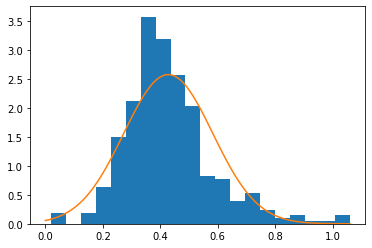

In [31]:
# concatenate
combined_sigma = np.concatenate([res_valid_gaus_params["Sigma"], random_valid_gaus_params["Sigma"]])

mu_fit, sig_fit =  norm.fit(combined_sigma)
plt.hist(combined_sigma, bins=20, density=1)

print(mu_fit, sig_fit)

x = np.linspace(0, combined_sigma.max(), 100)
prob_sig = norm.pdf(x, mu_fit, sig_fit)
plt.plot(x, prob_sig)

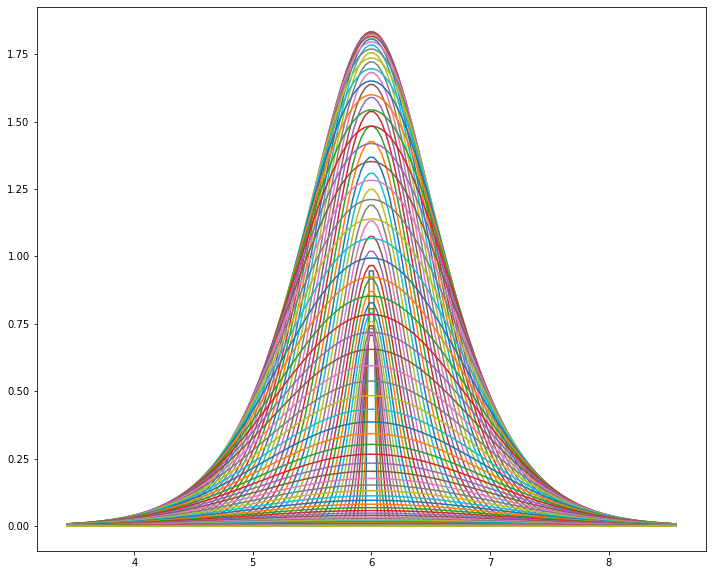

In [32]:
# Analytically over each of the mu;s, how to combine the sigmas?
max_sigma = mu_fit # the center of the distribution
increments = 150 

plt.figure(figsize=(12, 10))


total_y= np.zeros(increments)
for j in range(1,int(prob_sig.shape[0]), 1):
    fixed_sigma=x[j]
    t_sim = 6# np.log10(trimmed["t"].values[0])
    bins = np.linspace(t_sim -6*max_sigma, t_sim +6*max_sigma, increments)
    final_y = norm.pdf(bins, t_sim, fixed_sigma*2**0.5)* prob_sig[j]       
    total_y +=final_y
    plt.plot(bins, final_y )

end = time.time()
plt.show()

(150,)
150


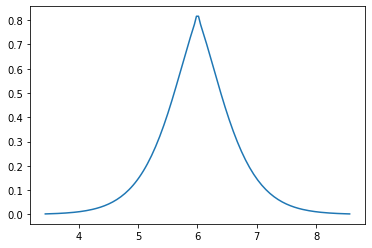

In [65]:
bins = np.linspace(t_sim -6*max_sigma, t_sim +6*max_sigma, increments)
print(total_y.shape)
print(increments)
area = np.trapz(total_y, bins)
total_y = total_y/area
plt.plot(bins, total_y)
width = (12*max_sigma)/(increments-1)
plt.show()

In [66]:
# res diff data in another file

res_deltatimes = pd.read_csv("../csvs/resonant/resonant_data.csv", index_col=0)

res_diff = res_deltatimes[ (np.log10(res_deltatimes["instability_time"])<8 ) &
                       (np.log10(res_deltatimes["shadow_instability_time"])<8 ) &
                       (np.log10(res_deltatimes["instability_time"])>5 ) &
                       (np.log10(res_deltatimes["shadow_instability_time"])>5 ) ]


print(res_diff.shape)
res_diff_times = np.log10(res_diff["instability_time"]) - np.log10(res_diff["shadow_instability_time"])


random_reduced_systems = random_test_systems[(random_test_systems["t"] > 10.**(5)) &
                              (random_test_systems["t"] < 1e8) &
                              (random_test_systems["t_shadow"] > 10.**5)
                              & (random_test_systems["t_shadow"]<1e8) ]
print(random_reduced_systems.shape)
random_diff_times = np.log10(random_reduced_systems["t"]) - np.log10(random_reduced_systems["t_shadow"])

(3395, 10)
(3702, 3)


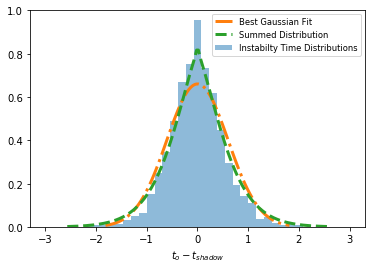

In [72]:
diff_times = np.concatenate([random_diff_times, res_diff_times])


fig, ax1 = plt.subplots()
bins = np.linspace(-3,3,40)
ax1.hist(res_diff_times, density = 1, alpha = 0.5, label= "Instabilty Time Distributions", bins = bins)

# from new note book
sig_fit = 0.42738509161195815 * np.sqrt(2.)

x = np.linspace(sig_fit*-3, sig_fit*3, 100)
prob_sig = norm.pdf(x, 0, sig_fit)
ax1.plot(x, prob_sig, linewidth = 3, label = "Best Gaussian Fit", ls = "-.")

bins = np.linspace(t_sim -6*max_sigma, t_sim +6*max_sigma, increments)
ax1.plot(bins-t_sim, total_y, label = "Summed Distribution", linewidth = 3, ls = "dashed")
        
ax1.legend(fontsize = 'small')
# ax2.legend()
ax1.set_xlabel(r'$t_o - t_{shadow}$')
plt.show()

In [79]:
trimmed_random_info_lower_mean= random_valid_gaus_params[(random_valid_gaus_params["Mean"] < 5.5) &
                                                   (random_valid_gaus_params["Mean"] > 4.0) ]
trimmed_random_info_higher_mean= random_valid_gaus_params[(random_valid_gaus_params["Mean"] < 7) &
                                                   (random_valid_gaus_params["Mean"] > 5.5) ]


trimmed_res_info_lower_mean= res_valid_gaus_params[(res_valid_gaus_params["Mean"] < 5.5) &
                                                   (res_valid_gaus_params["Mean"] > 4.0) ]
trimmed_res_info_higher_mean= res_valid_gaus_params[(res_valid_gaus_params["Mean"] < 7) &
                                                   (res_valid_gaus_params["Mean"] > 5.5) ]

Ks_2sampResult(statistic=0.12846790890269152, pvalue=0.07260410379032056)
Ks_2sampResult(statistic=0.0829963879454418, pvalue=0.49698137678519294)


Text(0.06, 0.5, 'Number of Initial Configurations')

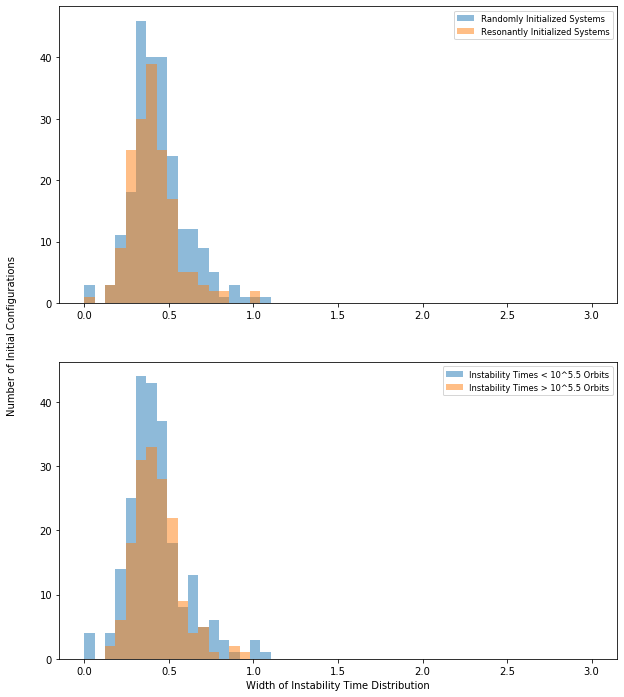

In [85]:

fig , (ax1, ax2) = plt.subplots(2, 1, figsize = (10, 12))

bins = np.linspace(0, 3, 50)
ax1.hist(random_valid_gaus_params["Sigma"], alpha = 0.5, bins = bins , label = "Randomly Initialized Systems")
ax1.hist(res_valid_gaus_params["Sigma"], alpha = 0.5, bins = bins, label = "Resonantly Initialized Systems")
print(ks_2samp(random_valid_gaus_params["Sigma"], res_valid_gaus_params["Sigma"]))
# ax1.set_xlabel("Sigma")
ax1.legend(loc="upper right", fontsize = 'small')

# combine the lower and higher sets
lower_sigmas = np.concatenate([trimmed_random_info_lower_mean["Sigma"], trimmed_res_info_lower_mean["Sigma"]])
higher_sigmas = np.concatenate([trimmed_random_info_higher_mean["Sigma"], trimmed_res_info_higher_mean["Sigma"]])

bins = np.linspace(0, 3, 50)
ax2.hist(lower_sigmas, alpha = 0.5, bins = bins , label = "Instability Times < 10^5.5 Orbits")
ax2.hist(higher_sigmas, alpha = 0.5, bins = bins, label = "Instability Times > 10^5.5 Orbits")
print(ks_2samp(lower_sigmas, higher_sigmas))
ax2.legend(loc="upper right", fontsize = 'small')
ax2.set_xlabel("Width of Instability Time Distribution")
fig.text(0.06, 0.5, 'Number of Initial Configurations', ha='center', va='center', rotation='vertical')


In [83]:
print(random_valid_gaus_params.shape, res_valid_gaus_params.shape)

(230, 8) (168, 7)
